In [1]:
import pandas as pd 
import numpy as np

num_train_samples = 1000
samples_per_class = int(num_train_samples/10)

x = pd.read_csv('data/mnist_train.csv').sample(frac = 1)
y = x['label']
x.drop(['label'], inplace = True, axis = 1)

x_test = pd.read_csv('data/mnist_test.csv')
y_test = x_test['label']
x_test.drop(['label'], inplace = True, axis = 1)

In [2]:
x_train, x_unlabeled = x[y.values == 0].values[:samples_per_class], x[y.values == 0].values[samples_per_class: ]
y_train, y_unlabeled = y[y.values == 0].values[:samples_per_class], y[y.values == 0].values[samples_per_class: ]


for i in range(1,10):
    x_train = np.concatenate([x_train, x[y.values == i].values[:samples_per_class]], axis = 0)
    y_train = np.concatenate([y_train, y[y.values == i].values[:samples_per_class]], axis = 0)
    
    x_unlabeled = np.concatenate([x_unlabeled, x[y.values == i].values[samples_per_class: ]], axis = 0)
    y_unlabeled = np.concatenate([y_unlabeled, y[y.values == i].values[samples_per_class: ]], axis = 0)

Shuffle the data

In [3]:
p = np.random.permutation(x_train.shape[0])
x_train, y_train = x_train[p], y_train[p]

p = np.random.permutation(x_unlabeled.shape[0])
x_unlabeled, y_unlabeled = x_unlabeled[p], y_unlabeled[p]

## Feature Engineering

In [4]:
from sklearn.preprocessing import Normalizer
scaler = Normalizer()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_unlabeled = scaler.transform(x_unlabeled)



In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 50)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)
x_unlabeled_pca = pca.transform(x_unlabeled)



In [6]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures()
x_train_poly = poly.fit_transform(x_train_pca)
x_test_poly = poly.transform(x_test_pca)
x_unlabeled_poly = poly.transform(x_unlabeled_pca)



## Effect of Increasing Data

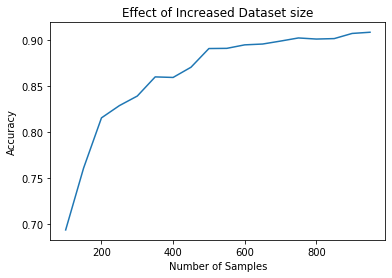

In [29]:
%matplotlib inline 
import matplotlib.pyplot as plt

num_samples = list(range(100, x_train_poly.shape[0], 50))
plt.plot(num_samples, accuracy_log)
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')
plt.title('Effect of Increased Dataset size')
plt.show()

## Baseline Estimates

In [8]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score


test_acc = []
for _ in range(10):
    log_reg  = SGDClassifier(loss = 'log', n_jobs = -1, alpha = 1e-5)
    log_reg.fit(x_train_poly, y_train)
    y_test_pred = log_reg.predict(x_test_poly)
    test_acc.append(accuracy_score(y_test_pred, y_test))
    
    
print('Test Accuracy: {:.2f}%'.format(np.array(test_acc).mean()*100))

Test Accuracy: 90.86%


## Semi-Supervised Training

In [21]:
# Concept similar to : https://www.analyticsvidhya.com/blog/2017/09/pseudo-labelling-semi-supervised-learning-technique/

class pseudo_labeling():

    
    def __init__(self, model, unlabelled_data,  sample_rate=0.01, upper_threshold = 0.6, lower_threshold = 0.4, verbose = False):
               
        self.sample_rate = sample_rate
        self.model = model
        self.unlabelled_data = unlabelled_data
        self.verbose = verbose
        self.upper_threshold = upper_threshold
        self.lower_threshold = lower_threshold
        
        # create a list of all the indices 
        self.unlabelled_indices = list(range(unlabelled_data.shape[0]))      
        
        # Number of rows to sample in each iteration
        self.sample_size = int(unlabelled_data.shape[0] * self.sample_rate)
        
        # Shuffle the indices
        np.random.shuffle(self.unlabelled_indices)

        
    
    def __pop_rows(self):
        """
        Function to sample indices without replacement
        """
        chosen_rows = self.unlabelled_indices[:self.sample_size]
        
        # Remove the chosen rows from the list of indicies (We are sampling w/o replacement)
        self.unlabelled_indices = self.unlabelled_indices[self.sample_size:]
        return chosen_rows
    
    
    def fit(self, X, y):
        
        """
        Perform pseudo labelling
        
        X: train features
        y: train targets
        
        """
        
        num_iters = int(len(self.unlabelled_indices)/self.sample_size)

        for _ in (tqdm_notebook(range(num_iters)) if self.verbose else range(num_iters)):
            
            # Get the samples
            chosen_rows = self.__pop_rows()

            # Fit to data
            self.model.fit(X, y.ravel())
            
            chosen_unlabelled_rows = self.unlabelled_data[chosen_rows,:]
            pseudo_labels_prob = self.model.predict_proba(chosen_unlabelled_rows)
            
            
            # We have 10 classes this means `predict_proba` returns an array of 10 probabilities per datapoint
            # We will first find the maximum probability and then find the rows which are within our threshold values
            label_probability = np.max(pseudo_labels_prob, axis = 1)
            labels_within_threshold = np.where((label_probability < self.lower_threshold) | (label_probability > self.upper_threshold))[0]
            
            
           # Use argmax to find the class with the highest probability
            pseudo_labels = np.argmax(pseudo_labels_prob[labels_within_threshold], axis = 1)
            chosen_unlabelled_rows = chosen_unlabelled_rows[labels_within_threshold]

            # Combine data
            X = np.vstack((chosen_unlabelled_rows, X))
            y = np.vstack((pseudo_labels.reshape(-1,1), np.array(y).reshape(-1,1)))

            # Shuffle 
            indices = list(range(X.shape[0]))
            np.random.shuffle(indices)

            X = X[indices]
            y = y[indices]     
        
    def predict(self, X):
        return self.model.predict(X)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)
    
     
    def decision_function(self, X):
        return self.model.decision_function(X)

    

In [22]:
from sklearn.linear_model import SGDClassifier 
from tqdm import tqdm_notebook

log_reg = SGDClassifier(loss = 'log', n_jobs = -1, alpha = 1e-5)

pseudo_labeller = pseudo_labeling(
        log_reg,
        x_unlabeled_poly,
        sample_rate = 0.04,
        verbose = True
    )

In [23]:
pseudo_labeller.fit(x_train_poly, y_train)

In [24]:
from sklearn.metrics import accuracy_score
y_test_pred = pseudo_labeller.predict(x_test_poly)
print('Test Accuracy: {:.2f}%'.format(accuracy_score(y_test_pred, y_test)*100))

Test Accuracy: 92.42%
